In [74]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import numpy as np
from collections import defaultdict
import string
from nltk import pos_tag
from nltk.tag import hmm
from nltk.corpus import treebank, brown, conll2000, reuters

import random
from datasets import load_dataset


In [75]:
nltk.download('stopwords')
nltk.download('wordnet') # download for lemmatization
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('reuters')
nltk.download('movie_reviews')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\trand\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\trand\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\trand\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\trand\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already

True

HMM + Viterbi for Optimization

In [76]:
def filter_punctuation(tagged_sentences):
    filtered_sentences = []
    for sentence in tagged_sentences:
        filtered_sentence = [(word, tag) for word, tag in sentence if word not in string.punctuation]
        if filtered_sentence:  # Only add non-empty sentences
            filtered_sentences.append(filtered_sentence)
    return filtered_sentences

In [77]:
def prepare_data(tagged_sentences):
    
    tagged_sentences = filter_punctuation(tagged_sentences)
    
    train_size = int(0.8 * len(tagged_sentences))  # 80% train, 20% test
    train_data = tagged_sentences[:train_size]
    test_data = tagged_sentences[train_size:]
    train_data = [s for s in train_data if s]
    test_data = [s for s in test_data if s]
    return train_data, test_data

In [78]:
def count_emissions_transitions(train_data):
    emission_counts = defaultdict(lambda: defaultdict(int))
    transition_counts = defaultdict(lambda: defaultdict(int))
    tag_counts = defaultdict(int)

    for sentence in train_data:
        previous_tag = '<s>'
        for word, tag in sentence:
            emission_counts[tag][word.lower()] += 1
            transition_counts[previous_tag][tag] += 1
            tag_counts[tag] += 1
            previous_tag = tag
        transition_counts[previous_tag]['</s>'] += 1
    
    return emission_counts, transition_counts, tag_counts

In [79]:
def calculate_probabilities(emission_counts, transition_counts, tag_counts):
    emission_prob = defaultdict(lambda: defaultdict(float))
    for tag, words in emission_counts.items():
        total_count = float(tag_counts[tag])
        for word, count in words.items():
            emission_prob[tag][word] = count / total_count

    transition_prob = defaultdict(lambda: defaultdict(float))
    for prev_tag, next_tags in transition_counts.items():
        total_count = float(sum(next_tags.values()))
        for next_tag, count in next_tags.items():
            transition_prob[prev_tag][next_tag] = count / total_count

    return emission_prob, transition_prob

In [80]:
# Viterbi algorithm
def viterbi(observation_seqs, transition_prob, emission_prob, tag_counts):
    states = list(tag_counts.keys())
    num_states = len(states)
    num_obs = len(observation_seqs)
    
    # Initialize the probability matrix and the backpointer matrix
    prob_matrix = np.zeros((num_states, num_obs))
    backtrack = np.zeros((num_states, num_obs), dtype=int)
    
    # Initial probabilities
    initial_states = np.array([transition_prob['<s>'][state] for state in states])
    
    # Populate the initial column of the probability matrix
    for state_index, state in enumerate(states):
        prob_matrix[state_index, 0] = initial_states[state_index] * emission_prob[state].get(observation_seqs[0], 1e-6)
    
    # Populate the probability matrix for t > 0
    for t in range(1, num_obs):
        for state_index, state in enumerate(states):
            max_prob, max_state = max(
                (prob_matrix[prev_state_index, t-1] * transition_prob[prev_state][state] * emission_prob[state].get(observation_seqs[t], 1e-6), prev_state_index)
                for prev_state_index, prev_state in enumerate(states)
            )
            prob_matrix[state_index, t] = max_prob
            backtrack[state_index, t] = max_state
    
    # Find the most probable state sequence
    optimal_path = np.zeros(num_obs, dtype=int)
    optimal_path[-1] = np.argmax(prob_matrix[:, -1])
    
    for t in range(num_obs - 2, -1, -1):
        optimal_path[t] = backtrack[optimal_path[t + 1], t + 1]
    
    # Convert indices back to state names
    optimal_tags = [states[state_index] for state_index in optimal_path]
    
    return optimal_tags

In [95]:
# Evaluate the model on the test data

def evaluate_hmm(test_data, transition_prob, emission_prob, tag_counts):
    words_list = []
    predicted_tags_list = []
    gold_tag_list = []
    correct = total = 0
    for sentence in test_data:
        words, gold_tags = zip(*sentence)
        words = [word.lower() for word in words]
        predicted_tags = viterbi(words, transition_prob, emission_prob, tag_counts)
        correct += sum(p == g for p, g in zip(predicted_tags, gold_tags))
        total += len(gold_tags)
        # Print the comparison for each sentence
        words_list.append(' '.join(words))
        predicted_tags_list.append(predicted_tags)
        gold_tag_list.append(gold_tags)
        # print(f"Sentence: {' '.join(words)}")
        # print(f"Predicted tags: {predicted_tags}")
        # print(f"Actual tags:    {gold_tags}")
        # print()
    #showing the first 5 performance 
    for i in range(5):
        print(f"Sentence: {words_list[i]}")
        print(f"Predicted tags: {predicted_tags_list[i]}")
        print(f"Actual tags:    {gold_tag_list[i]}")
    return correct / total, gold_tag_list, predicted_tags_list

In [96]:
def train_and_evaluate(corpus_name, tag_sentence):
    train_data, test_data = prepare_data(tag_sentence)
    emission_counts, transition_counts, tag_counts = count_emissions_transitions(train_data)
    emission_prob, transition_prob = calculate_probabilities(emission_counts, transition_counts, tag_counts)
    accuracy = evaluate_hmm(test_data, transition_prob, emission_prob, tag_counts)[0]
    print(f'{corpus_name} Corpus Accuracy: {accuracy:.4f}')

In [97]:
tagged_sentences_treebank = treebank.tagged_sents(tagset='universal')
train_and_evaluate('Treebank', tagged_sentences_treebank)

Sentence: the latest 10-year notes were quoted at 100 22\/32 *-1 to yield 7.88 compared with 100 16\/32 to yield 7.90
Predicted tags: ['DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'NUM', 'NUM', 'X', 'PRT', 'VERB', 'NUM', 'VERB', 'ADP', 'NUM', 'X', 'PRT', 'VERB', 'NUM']
Actual tags:    ('DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'NUM', 'NUM', 'X', 'PRT', 'VERB', 'NUM', 'VERB', 'ADP', 'NUM', 'NUM', 'PRT', 'VERB', 'NUM')
Sentence: the discount rate on three-month treasury bills was essentially unchanged at 7.79 while the rate on six-month bills was slightly lower at 7.52 compared with 7.60 tuesday
Predicted tags: ['DET', 'NOUN', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'VERB', 'ADV', 'ADJ', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'VERB', 'ADV', 'ADJ', 'ADP', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN']
Actual tags:    ('DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'VERB', 'ADV', 'ADJ', 'ADP', 'NUM', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'VERB', 'ADV',

In [84]:
tagged_sentences_brown = brown.tagged_sents(tagset='universal')
train_and_evaluate('Brown', tagged_sentences_brown)


Sentence: he was courteous and casual about it as though it were of no consequence
Predicted tags: ['PRON', 'VERB', 'ADJ', 'CONJ', 'ADJ', 'ADP', 'PRON', 'ADV', 'ADP', 'PRON', 'VERB', 'ADP', 'DET', 'NOUN']
Actual tags:    ('PRON', 'VERB', 'ADJ', 'CONJ', 'ADJ', 'ADP', 'PRON', 'ADP', 'ADP', 'PRON', 'VERB', 'ADP', 'DET', 'NOUN')
Sentence: he's always like that in spite of being a big man
Predicted tags: ['PRT', 'ADV', 'ADP', 'PRON', 'ADP', 'NOUN', 'ADP', 'VERB', 'DET', 'ADJ', 'NOUN']
Actual tags:    ('PRT', 'ADV', 'ADP', 'DET', 'ADP', 'ADP', 'ADP', 'VERB', 'DET', 'ADJ', 'NOUN')
Sentence: when you see him you'll notice his habit of fingering i might almost say stroking a large mole with black hairs on it by his right temple
Predicted tags: ['ADV', 'PRON', 'VERB', 'PRON', 'PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'PRON', 'VERB', 'ADV', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'PRON', 'ADP', 'DET', 'ADJ', 'NOUN']
Actual tags:    ('ADV', 'PRON', 'VERB', 'PRON', 'PRT

In [85]:
tagged_sentences_conll2000 = conll2000.tagged_sents(tagset='universal')
train_and_evaluate('Conll2000', tagged_sentences_conll2000)

Sentence: the debentures were issued in the face amount of 46 million on july 11 1988 the ashland ky. coal mining water transportation and construction company said
Predicted tags: ['DET', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'NOUN', 'ADP', 'NUM', 'NUM', 'ADP', 'NOUN', 'NUM', 'NUM', 'DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN', 'VERB']
Actual tags:    ('DET', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'NOUN', 'ADP', 'NUM', 'NUM', 'ADP', 'NOUN', 'NUM', 'NUM', 'DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN', 'VERB')
Sentence: the company said the redemption is permitted because the price of addington 's stock has equaled or exceeded 19.60 for 20 consecutive trading days a condition set in the terms of the debentures
Predicted tags: ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PRT', 'NOUN', 'VERB', 'NOUN', 'CONJ', 'VERB', 'VERB', 'ADP', 'NUM', 'ADJ', 'NOUN', 'NOUN', '

In [86]:
reuters_files = reuters.fileids()

# Tokenize the raw text into sentences and apply POS tagging
tagged_sentences_reuters = []
for file_id in reuters_files:
    raw_text = reuters.raw(file_id)
    sentences = sent_tokenize(raw_text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged_sentence = pos_tag(words, tagset='universal')
        tagged_sentences_reuters.append(tagged_sentence)
        
train_and_evaluate('Reuters', tagged_sentences_reuters)

Sentence: large banks -- those with assets of one billion dlrs or more -- reporting fourth-quarter losses totaled 22 the fdic said
Predicted tags: ['ADJ', 'NOUN', '.', 'DET', 'ADP', 'NOUN', 'ADP', 'NUM', 'NUM', 'NOUN', 'CONJ', 'ADJ', '.', 'VERB', 'ADJ', 'NOUN', 'VERB', 'NUM', 'DET', 'NOUN', 'VERB']
Actual tags:    ('ADJ', 'NOUN', '.', 'DET', 'ADP', 'NOUN', 'ADP', 'NUM', 'NUM', 'NOUN', 'CONJ', 'ADJ', '.', 'VERB', 'ADJ', 'NOUN', 'VERB', 'NUM', 'DET', 'NOUN', 'VERB')
Sentence: seidman said it was too early to say what effect brazil's moratorium on debt interest payments would have on u.s. banks
Predicted tags: ['NOUN', 'VERB', 'PRON', 'VERB', 'ADV', 'ADJ', 'PRT', 'VERB', 'PRON', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'NOUN', 'NOUN']
Actual tags:    ('NOUN', 'VERB', 'PRON', 'VERB', 'ADV', 'ADJ', 'PRT', 'VERB', 'PRON', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'NOUN', 'NOUN')
Sentence: he said bank deregulation had g

### We will plot the accuracy comparison between model 

In [87]:
import matplotlib.pyplot as plt

In [88]:
list_corpus = ['Treebank', 'Brown', 'Conll2000', 'Reuters']
hmm_viterbi_accuracy = [0.9154, 0.9340, 0.9356, 0.9262]
hmm_accuracy = [0.4651, 0.6078, 0.5453, 0.6407] #taking from the built in treebank hmm model

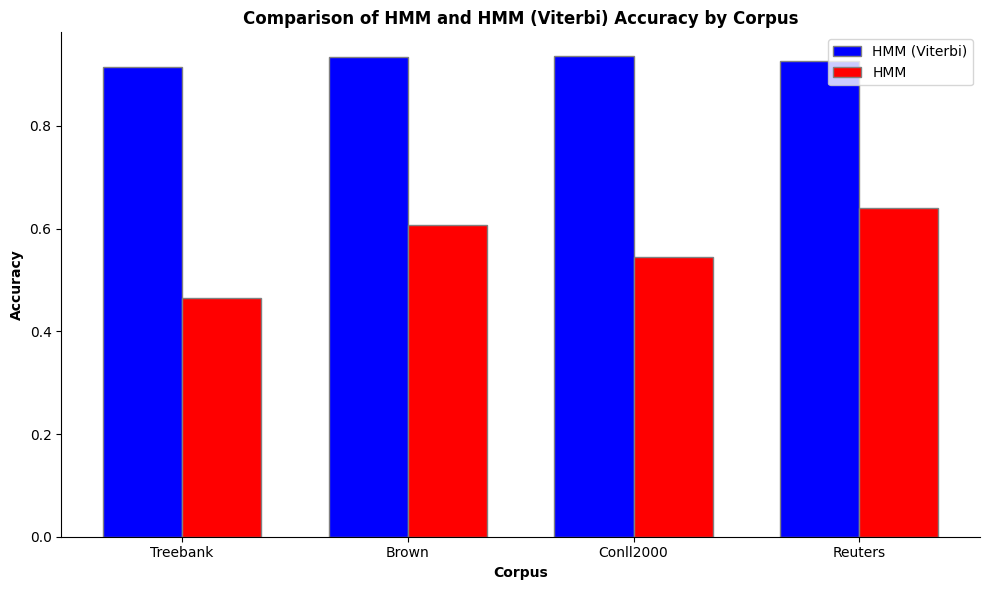

In [94]:
# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of bars
bar_width = 0.35

# Set position of bar on X axis
r1 = range(len(list_corpus))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.bar(r1, hmm_viterbi_accuracy, color='b', width=bar_width, edgecolor='grey', label='HMM (Viterbi)')
plt.bar(r2, hmm_accuracy, color='r', width=bar_width, edgecolor='grey', label='HMM')

# Add xticks on the middle of the group bars
plt.xlabel('Corpus', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(list_corpus))], list_corpus)
# Add ylabel and title
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Comparison of HMM and HMM (Viterbi) Accuracy by Corpus', fontweight='bold')
# Add legend
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
# Show plot
plt.tight_layout()
plt.show()